### mouse_PDAC_Tutorial

This tutorial will illustrate how to perform cell type abundance deconvolution on mouse_PDAC dataset using GraphDec.


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
import random
import numpy as np
import scanpy as sc
import pandas as pd

from model import GraphDec
from utils import compute_metrics

os.environ["CUDA_VISIBLE_DEVICES"] = "2" # Please modify this according to your own situation.

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
set_seed(42)

Load data. Please make sure you have run `mixup/mouse_PDAC_mix.ipynb` in advance.

In [2]:
dataroot = '/public/home/syj/scpDeconv/dataset/mixup_data/' # Please modify this to your address.
dataname = 'mouse_PDAC'
data = sc.read_h5ad(dataroot + dataname + '.h5ad')

Data Preprocessing.

In [3]:
if dataname in ['bmmc_15', 'bmmc_50', 'bmmc_200', 'pbmc_data', 'pancreas', 'mouse_brain', 'mouse_PDAC']:
    sc.pp.normalize_total(data, target_sum=1e4)
    sc.pp.log1p(data)

train_data = data[data.obs['batch'] == '0']
test_data = data[data.obs['batch'] != '0']

if train_data.shape[1] > 500:
    sc.pp.highly_variable_genes(train_data, n_top_genes=500)
    test_data = test_data[:, train_data.var_names][:, train_data.var['highly_variable']]
    train_data = train_data[:, train_data.var['highly_variable']]
else:
    test_data = test_data[:, train_data.var_names]

print(train_data)
print(test_data)

View of AnnData object with n_obs × n_vars = 1000 × 500
    obs: 'CAF', 'CancerCell', 'Immune', 'batch'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_types', 'spatial', 'log1p', 'hvg'
View of AnnData object with n_obs × n_vars = 108 × 500
    obs: 'CAF', 'CancerCell', 'Immune', 'batch'
    uns: 'cell_types', 'spatial', 'log1p'


Run GraphDec.

In [4]:
model = GraphDec(train_data, test_data, num_epochs=100, learning_rate=5e-4)
model.train()
pred = model.prediction(torch.FloatTensor(test_data.X.astype(np.float32)).cuda())

Embedding        : 100%|██████████| 200/200 [00:03<00:00, 59.74it/s]


============= Epoch 100/100 =============
CCC: 0.338 , RMSE: 0.244 , Pearson: 0.354 , Time: 3.72 s


Calculate Quantitative Metrics.

In [5]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from math import sqrt

def ccc(pred, gt):
    numerator = 2 * np.corrcoef(gt, pred)[0][1] * np.std(gt) * np.std(pred)
    denominator = np.var(gt) + np.var(pred) + (np.mean(gt) - np.mean(pred)) ** 2
    ccc_value = numerator / denominator
    return ccc_value

def compute_metrics(pred, gt):
    x = pred
    y = gt
    CCC = ccc(x, y)
    RMSE = sqrt(mean_squared_error(x, y))
    Corr = pearsonr(x, y)[0]
    return CCC, RMSE, Corr

df = pd.DataFrame(pred, columns=train_data.uns['cell_types'])
label = np.array([test_data.obs[ctype] for ctype in train_data.uns['cell_types']], dtype=np.float32).T
label = pd.DataFrame(label, columns=train_data.uns['cell_types'])

print('CAF')
epoch_ccc, epoch_rmse, epoch_corr = compute_metrics(df['CAF'], label['CAF'])
print('CCC:', round(epoch_ccc, 3), ', RMSE:', round(epoch_rmse, 3), ', Pearson:', round(epoch_corr, 3))
print('CancerCell')
epoch_ccc, epoch_rmse, epoch_corr = compute_metrics(df['CancerCell'], label['CancerCell'])
print('CCC:', round(epoch_ccc, 3), ', RMSE:', round(epoch_rmse, 3), ', Pearson:', round(epoch_corr, 3))
print('Immune')
epoch_ccc, epoch_rmse, epoch_corr = compute_metrics(df['Immune'], label['Immune'])
print('CCC:', round(epoch_ccc, 3), ', RMSE:', round(epoch_rmse, 3), ', Pearson:', round(epoch_corr, 3))

CAF
CCC: 0.125 , RMSE: 0.328 , Pearson: 0.408
CancerCell
CCC: 0.472 , RMSE: 0.202 , Pearson: 0.731
Immune
CCC: 0.594 , RMSE: 0.176 , Pearson: 0.805


In [6]:
import pickle

pickle.dump(df, open('/public/home/syj/scpDeconv/GraphDEC/results/data/ours_mouse_PDAC.pkl', 'wb'))

Visualization. You need to install the cell2location package.

In [1]:
import pickle
import warnings
import cell2location
import scanpy as sc
warnings.filterwarnings("ignore")

adata = sc.read_h5ad("/public/home/syj/scpDeconv/dataset/raw_data/mouse_PDAC_spatial_proteomics.h5ad")
adata.obs['CAF'] = adata.uns['celltype_gd']['CAF']
adata.obs['Immune'] = adata.uns['celltype_gd']['Immune']
adata.obs['CancerCell'] = adata.uns['celltype_gd']['CancerCell']
adata

/public/home/syj/miniconda3/envs/cell2loc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AnnData object with n_obs × n_vars = 108 × 2837
    obs: 'ID2', 'Spot', 'X', 'Y', 'CAF', 'Immune', 'CancerCell'
    uns: 'celltype_gd'
    obsm: 'spatial'

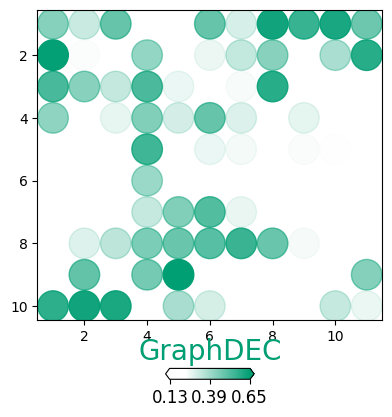

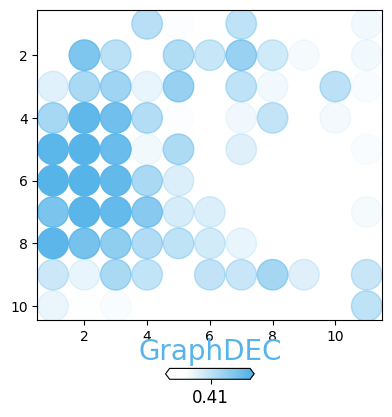

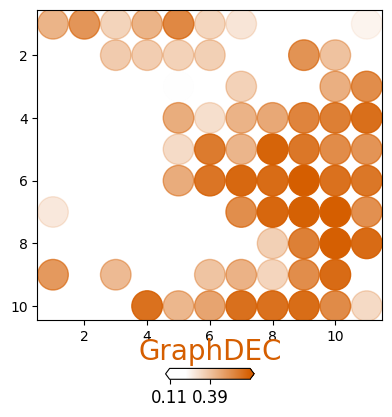

In [2]:
df = pickle.load(open('/public/home/syj/scpDeconv/GraphDEC/results/data/ours_mouse_PDAC.pkl', 'rb'))

adata_GraphDEC = adata.copy()
adata_GraphDEC.obs['GraphDEC'] = df['CAF'].values
fig_GraphDEC_CAF = cell2location.plt.plot_spatial(adata_GraphDEC,show_img=False,labels=["GraphDEC"],color=["GraphDEC"],circle_diameter=22,reorder_cmap=[3],max_color_quantile=1,plt_axis=True)
adata_GraphDEC.obs['GraphDEC'] = df['Immune'].values
fig_GraphDEC_Immune = cell2location.plt.plot_spatial(adata_GraphDEC,show_img=False,labels=["GraphDEC"],color=["GraphDEC"],circle_diameter=22,reorder_cmap=[2],max_color_quantile=1,plt_axis=True)
adata_GraphDEC.obs['GraphDEC'] = df['CancerCell'].values
fig_GraphDEC_CancerCell = cell2location.plt.plot_spatial(adata_GraphDEC,show_img=False,labels=["GraphDEC"],color=["GraphDEC"],circle_diameter=22,reorder_cmap=[1],max_color_quantile=1,plt_axis=True)